# Amazon Reviews Sentiment Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with sentiment analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a prediction model for rating, based on NLP.

## Import

In [2]:
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset reading

Util functions to read from JSON and convert into pandas dataframe:

In [53]:
#%%heat
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def readfile():
    file = gzip.open(r"datasets\amazon-5-core\reviews_Video_Games_5.json.gz", 'r')
    N = 1000
    for lines in grouper(file, N, ''):
        lines = [x for x in lines if isinstance(x, str) == False] # last \n is a string => error
        yield eval(b'[' + b','.join(lines) + b']')

def prova():          
    df = []
    for d in readfile():
        df.append(d)
    return pd.DataFrame(df)

%time data = prova()
data.shape

Wall time: 32.2 s


(232, 1000)

In [54]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df

Reading from JSON

In [55]:
%time dfull = read_dataset("reviews_Video_Games_5.json.gz")

Wall time: 36 s


Columns renaming

In [14]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

#### Reading performances

!pip install py-heat-magic
%load_ext heat

%%heat
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df

dfull = read_dataset("reviews_Video_Games_5.json.gz")

![reading performances](docs/images/00_dataset_reading_performances.png "Reading performances")

##  Dataset description

### Shape and schema

In [15]:
dfull.shape

(231780, 9)

In [16]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231780 entries, 0 to 231779
Data columns (total 9 columns):
productID         231780 non-null object
helpful           231780 non-null object
rating            231780 non-null float64
text              231780 non-null object
reviewTime        231780 non-null object
userID            231780 non-null object
userName          228967 non-null object
summary           231780 non-null object
unixReviewTime    231780 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 10.6+ MB


Little dataset preview:

In [17]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,0700099867,"[8, 12]",1.0,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4.0,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1.0,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600


### Columns analysis

#### Users and products

In [18]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Avarage REVIEWS PER USER: ", rows/n_users)
print("Avarage REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  231780
Number of USERS:  24303
Number of PRODUCTS:  10672
Avarage REVIEWS PER USER:  9.537094185902975
Avarage REVIEWS PER PRODUCT:  21.718515742128936


#### Datetime

In [19]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  1999-10-14 00:00:00
Last date:  2014-07-22 00:00:00


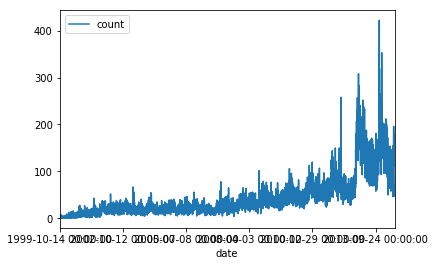

In [20]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

#### Rating

In [21]:
dfull['rating'].mean()

4.086396582966606

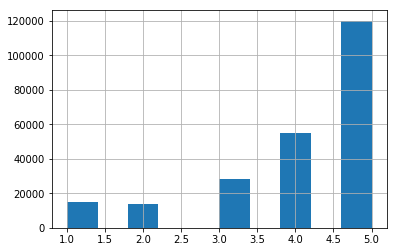

In [22]:
dfull['rating'].hist()

### Data filtering

#### Target rebalancing

### Words analysis

In [23]:
from PIL import Image
from wordcloud import WordCloud

from collections import Counter
import itertools

In [24]:
sentences = list((dfull.summary))
sentences
# flat_list = [item for sublist in sentences for item in sublist]
# flat_list
# c = Counter(sentences)
# c.most_common()

["Pay to unlock content? I don't think so.",
 'Good rally game',
 'Wrong key',
 'awesome game, if it did not crash frequently !!',
 'DIRT 3',
 'Good racing game, terrible Windows Live Requirement',
 'A step up from Dirt 2 and that is terrific!',
 'Crash 3 is correct name AKA Microsoft',
 "A great game ruined by Microsoft's account management system",
 "Couldn't get this one to work",
 'Best in the series!',
 'A 5 stars winner!',
 'Cars',
 'It might have been a good game, but I never found out because the ...',
 "Don't waste your money",
 'Not as good as DiRT 2',
 'An overlooked gem in the Forza/GT treasure trove',
 'Better than Dirt 2, Except for....',
 'Colin McRae CRASH 3!',
 'The first one was much better.',
 'this games is amazing!!!!!!!!',
 'Abysmal support from Codemasters',
 'Games for Windows Live...',
 'Fun',
 'BEST GRAPHICS OF ANY GAME SO FAR !!!!',
 'Works good!',
 'Yet Another Great Expansion',
 'USB microphone',
 'works with RB3 on the 360',
 'too fun for words',
 'Limited

In [ ]:
import itertools

sentences = (list(itertools.chain(dfull)))
flat_list = [item for sublist in sentences for item in sublist]
  
fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="white").generate(" ".join(flat_list))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")